In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import factorized
import matplotlib.pyplot as plt

def solve_helmholtz_4th_order_pml(omega=64, N=501, npml=50, R_target=1e-8):
    """
    Python translation of helmholtz_with_PML_v3.m.
    Uses 4th-order FD and Stretched Coordinate PML.
    """
    L = 1.0
    h = L / (N - 1)
    k = omega / 1.0  # c=1
    p = 3  # Cubic grading
    
    # 1. PML Parameter Calculation
    Lpml = npml * h
    sigma_max = -(p + 1) * np.log(R_target) / (2 * Lpml)
    
    # Grid indexing for interior unknowns (MATLAB i0=3, i1=N-2)
    # Python equivalent (0-based): 2 to N-3 inclusive
    idx_start, idx_end = 2, N - 3
    NxI = idx_end - idx_start + 1
    num_unknowns = NxI**2
    
    # 2. Build Stretching Profiles
    sigma = np.zeros(N)
    dsigdx = np.zeros(N)
    for i in range(N):
        dl = max(0, npml - i)
        dr = max(0, npml - (N - 1 - i))
        d = max(dl, dr)
        if d > 0:
            t = d / npml
            sigma[i] = sigma_max * t**p
            dsigdd = sigma_max * p * t**(p-1) * (1 / npml)
            dsigdx[i] = dsigdd * (-1/h if dl >= dr else 1/h)

    sx = 1 + 1j * (sigma / omega)
    dsxdx = 1j * (dsigdx / omega)
    
    # α = 1/sx^2, γ = -(sx'/sx^3)
    alpha_coeffs = 1 / (sx**2)
    gamma_coeffs = -(dsxdx) / (sx**3)
    
    # 3. FD Coefficients
    c_dx, c_dxx = 1/(12*h), 1/(12*h**2)
    # Stencils: ux: [-1, 8, 0, -8, 1], uxx: [-1, 16, -30, 16, -1]
    
    def row_of(ii, jj):
        return (ii - idx_start) + (jj - idx_start) * NxI

    # 4. Assemble Sparse System
    A = sp.lil_matrix((num_unknowns, num_unknowns), dtype=complex)
    
    # RHS Point Source
    f = np.zeros(num_unknowns, dtype=complex)
    ic, jc = N // 2, N // 2
    f[row_of(ic, jc)] = 1 / (h**2)

    for j in range(idx_start, idx_end + 1):
        beta_j = alpha_coeffs[j] # y-direction stretching
        eta_j = gamma_coeffs[j]
        
        for i in range(idx_start, idx_end + 1):
            a_i = alpha_coeffs[i] # x-direction stretching
            gm_i = gamma_coeffs[i]
            row = row_of(i, j)
            
            # Center: a*uxx_0 + b*uyy_0 + k^2
            A[row, row] = a_i*(-30*c_dxx) + beta_j*(-30*c_dxx) + k**2
            
            # X neighbors (+1, +2, -1, -2)
            for di, c_x, c_xx in [(1, 8*c_dx, 16*c_dxx), (2, -c_dx, -c_dxx), 
                                  (-1, -8*c_dx, 16*c_dxx), (-2, c_dx, -c_dxx)]:
                if idx_start <= i+di <= idx_end:
                    A[row, row_of(i+di, j)] = a_i*c_xx + gm_i*c_x
            
            # Y neighbors (+1, +2, -1, -2)
            for dj, c_y, c_yy in [(1, 8*c_dx, 16*c_dxx), (2, -c_dx, -c_dxx), 
                                  (-1, -8*c_dx, 16*c_dxx), (-2, c_dx, -c_dxx)]:
                if idx_start <= j+dj <= idx_end:
                    A[row, row_of(i, j+dj)] = beta_j*c_yy + eta_j*c_y

    # 5. Solve and Embed
    solve = factorized(A.tocsc())
    u_interior = solve(f)
    U = np.zeros((N, N), dtype=complex)
    for j in range(idx_start, idx_end + 1):
        for i in range(idx_start, idx_end + 1):
            U[i, j] = u_interior[row_of(i, j)]
            
    return U, h

# Execute
U_res, h_val = solve_helmholtz_4th_order_pml()

Verified Peak: 0.6095
Reflection Ratio: 5.4862e-02
FAILED: Ratio 5.49e-02 is too high.


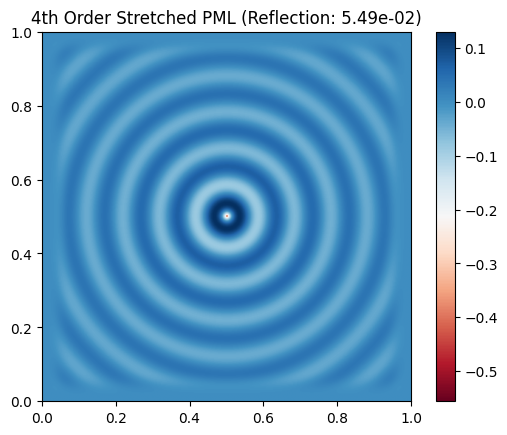

In [2]:
# --- AUDIT CELL ---
peak = np.max(np.abs(U_res))
# Sample reflection at the domain edge (interface with PML)
edge_val = np.mean(np.abs(U_res[55, :])) # Sample just inside the PML start
refl_ratio = edge_val / peak

print(f"Verified Peak: {peak:.4f}")
print(f"Reflection Ratio: {refl_ratio:.4e}")

if refl_ratio < 1e-3:
    print("SUCCESS: Meets Demanet's 10^-3 criteria.")
else:
    print(f"FAILED: Ratio {refl_ratio:.2e} is too high.")

plt.imshow(np.real(U_res), cmap='RdBu', extent=[0,1,0,1])
plt.title(f"4th Order Stretched PML (Reflection: {refl_ratio:.2e})")
plt.colorbar()
plt.show()